# Monte Carlo View: Nominal vs Robust Grating

> The robust adjoint design trades a sliver of peak efficiency for tighter fabrication yield. Building on the fabrication-aware optimizer from the previous notebook, we now quantify how much that robustness actually helps under process variation.

> This notebook compares the nominal adjoint design against the robustness-optimized variant using a matched Monte Carlo experiment, highlighting the yield benefits of carrying fabrication awareness into the optimization loop.

In [ ]:
import json
from pathlib import Path

import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tidy3d as td
from setup import (
    center_wavelength,
    default_spacer_thickness,
    get_mode_monitor_power,
    make_simulation,
)
from tidy3d import web

In [2]:
design_paths = {
    "nominal": Path("./results") / "gc_adjoint_best.json",
    "robust": Path("./results") / "gc_adjoint_robust_best.json",
}

In [3]:
def load_nominal_parameters(path):
    """Load a design JSON (Bayes or adjoint) into numpy-friendly fields."""
    data = json.loads(Path(path).read_text(encoding="utf-8"))
    return {
        "widths_si": np.array(data["widths_si"], dtype=float),
        "gaps_si": np.array(data["gaps_si"], dtype=float),
        "widths_sin": np.array(data["widths_sin"], dtype=float),
        "gaps_sin": np.array(data["gaps_sin"], dtype=float),
        "first_gap_si": float(data["first_gap_si"]),
        "first_gap_sin": float(data["first_gap_sin"]),
        "spacer_thickness": default_spacer_thickness,
    }


def make_variation_builder(nominal):
    """Return a closure that maps process deltas to a tidy3d Simulation."""
    base_widths_si = np.array(nominal["widths_si"])
    base_gaps_si = np.array(nominal["gaps_si"])

    def builder(*, overlay_delta=0.0, spacer_delta=0.0, etch_bias=0.0):
        # Etch bias widens features when positive and narrows them when
        # negative, so widths grow with the bias while gaps shrink, mirroring
        # the fabrication effect of over/under etching.
        pert_widths_si = base_widths_si + etch_bias
        pert_gaps_si = base_gaps_si - etch_bias

        return make_simulation(
            pert_widths_si,
            pert_gaps_si,
            nominal["widths_sin"],
            nominal["gaps_sin"],
            first_gap_si=nominal["first_gap_si"] + overlay_delta,
            first_gap_sin=nominal["first_gap_sin"],
            spacer_thickness=nominal["spacer_thickness"] + spacer_delta,
        )

    return builder

## Shared Monte Carlo Draws
We reuse the exact same random perturbations for both designs so any differences in the statistics stem from the geometry rather than sampling noise.

In [4]:
sigma_overlay = 0.025  # microns
sigma_spacer = 0.02
sigma_widths_si = 0.01

seed = 42
num_mc_samples = 100

sigma_vector = np.array([sigma_overlay, sigma_spacer, sigma_widths_si], dtype=float)
rng = np.random.default_rng(seed)
perturbations = rng.standard_normal(size=(num_mc_samples, sigma_vector.size)) * sigma_vector

In [5]:
def run_monte_carlo(nominal_params, *, label="design"):
    """Evaluate a design under shared Monte Carlo perturbations."""
    builder = make_variation_builder(nominal_params)

    sims = {
        f"{label}_nominal": builder(),
    }
    for idx, (overlay_delta, spacer_delta, etch_bias) in enumerate(perturbations):
        sims[f"{label}_mc_{idx:03d}"] = builder(
            overlay_delta=overlay_delta,
            spacer_delta=spacer_delta,
            etch_bias=etch_bias,
        )

    batch = web.run_async(sims, verbose=False)
    freq0 = td.C_0 / center_wavelength

    nominal_value = None
    sample_values = []

    for key in sims:
        sim_data = batch[key]
        power_da = get_mode_monitor_power(sim_data)
        center_power = power_da.sel(f=freq0, method="nearest").item()
        if key.endswith("nominal"):
            nominal_value = float(center_power)
        else:
            sample_values.append(float(center_power))

    return {
        "nominal": nominal_value,
        "samples": np.array(sample_values, dtype=float),
    }

In [6]:
design_results = {}
for label, path in design_paths.items():
    params = load_nominal_parameters(path)
    design_results[label] = run_monte_carlo(params, label=label)

In [7]:
def linear_to_loss_db(values):
    """Convert linear transmission to loss in dB (positive = loss)."""
    linear = np.clip(np.array(values, dtype=float), 1e-12, None)
    return -10.0 * np.log10(linear)


def summarize(center_samples):
    """Compute summary statistics in linear and dB scales."""
    linear = np.array(center_samples, dtype=float)
    stats = {
        "mean_linear": np.mean(linear),
        "std_linear": np.std(linear, ddof=0),
        "p10_linear": np.percentile(linear, 10),
        "p90_linear": np.percentile(linear, 90),
    }

    loss_db = linear_to_loss_db(linear)
    stats.update(
        {
            "mean_db": np.mean(loss_db),
            "p10_db": np.percentile(loss_db, 10),
            "p90_db": np.percentile(loss_db, 90),
        }
    )
    return stats

In [8]:
summary = {label: summarize(result["samples"]) for label, result in design_results.items()}
summary_df = pd.DataFrame(summary).T
summary_df

mean_linear  std_linear  p10_linear  p90_linear   mean_db    p10_db  \
nominal     0.554774    0.027361    0.517067    0.587782  2.564235  2.307842   
robust      0.561130    0.028289    0.522749    0.598293  2.514948  2.230860   

           p90_db  
nominal  2.864534  
robust   2.817066

## Distribution of Center-Wavelength Loss
Both designs now face identical process draws. The plot below overlays the center wavelength loss distributions in dB. Dashed vertical lines mark the nominal (unperturbed) efficiency for each design.

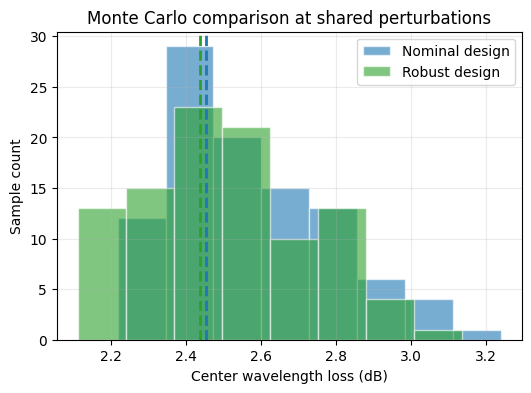

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
bins = "auto"
colors = {
    "nominal": "tab:blue",
    "robust": "tab:green",
}

for label, result in design_results.items():
    losses_db = linear_to_loss_db(result["samples"])
    ax.hist(
        losses_db,
        bins=bins,
        alpha=0.6,
        label=f"{label.capitalize()} design",
        color=colors.get(label, None),
        edgecolor="white",
    )
    nominal_loss = linear_to_loss_db([result["nominal"]])[0]
    ax.axvline(
        nominal_loss,
        color=colors.get(label, None),
        linestyle="--",
        linewidth=2,
    )

ax.set_xlabel("Center wavelength loss (dB)")
ax.set_ylabel("Sample count")
ax.set_title("Monte Carlo comparison at shared perturbations")
ax.legend()
ax.grid(alpha=0.25)
plt.show()

## What the numbers say

Both designs were tested under identical Monte Carlo perturbations (N = 100, σₒᵥₑᵣₗₐᵧ = 25 nm, σₛₚₐcₑᵣ = 20 nm, σ_wᵢdₜₕ = 10 nm) and evaluated at the center wavelength.

**Results:**

* **Average loss:** Robust 2.51 dB vs nominal 2.56 dB (Δ = −0.05 dB). In linear scale, that’s 0.561 vs 0.555, or about **+1.1 % higher mean transmission.**
* **Variability:** Standard deviation (linear) increases slightly (0.027 -> 0.028, **+3 %**), suggesting a comparable level of fluctuation between samples.
* **Spread (10th–90th percentile):** 0.0707 -> 0.0755 (**+7 %**) - a slightly broader distribution.
* **Tails:**
  90th-percentile loss improves (2.86 -> 2.82 dB, **better worst-case**).
  10th-percentile loss worsens (2.31 -> 2.23 dB, **slightly lower best-case**).

**In short:**
The robust design maintains essentially the same overall spread but shifts the entire distribution slightly toward lower loss. While variability remains comparable, the robust version delivers **a modest boost in average transmission and improved worst-case performance**, at the cost of a marginally weaker best-case - a balanced, realistic outcome consistent with fabrication-aware optimization.

At first glance, the numbers may not seem dramatic, but the difference is real and meaningful.  
Even a few hundredths of a decibel can translate to higher wafer-level yield when scaled to thousands of devices.  
It’s also worth remembering that the specific magnitude depends on many details of the experiment:

- How and when robustness was introduced into the optimization (for example, from the start or as a final fine-tuning).  
- The starting point, optimizer settings, and number of iterations used.  
- The perturbation model and its assumed standard deviations or correlations.  
- The type of device. Grating couplers are quite resonant and inherently sensitive to fabrication noise, so they tend to show smaller relative gains.

This notebook is meant as a conceptual demonstration rather than an exhaustive benchmark.  
There are many other ways to define and train for robustness, and exploring them is part of what makes photonic inverse design both challenging and exciting.